### Import Libraries

In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
wordnet_lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

import string
import torch
import pickle
from heapq import nlargest
import sys
import spacy
# !pip install truecase
import truecase
from spacy import displacy
from collections import Counter
from nltk.tag import StanfordNERTagger
import en_core_web_sm
nlp = en_core_web_sm.load()
from pprint import pprint
# !pip install unidecode
from unidecode import unidecode
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel, euclidean_distances
import warnings
from tqdm._tqdm_notebook import tqdm_notebook
from scipy.spatial import distance
import numpy as np
import re
# !pip install sentence_transformers
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.cluster.util import cosine_distance
import tensorflow as tf
import transformers
# !pip install sent2vec
from sent2vec.vectorizer import Vectorizer as S2vectorizer
tqdm_notebook.pandas()
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import networkx as nx

#import pipelines
from transformers import pipeline
nlp2 = pipeline("question-answering")

pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', 0)

<ipython-input-1-3933fe0d3274>:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Data
Start from here

In [2]:
#Read the pickle file
with open('../data/legal_cleaned_2_apr.pkl', "rb") as fh:
    df = pickle.load(fh)

In [28]:
legal_context_mapping = {}
for idx, rows in df.iterrows():
    legal_context_mapping[rows['context']] = rows['Unnamed: 0']

In [23]:
qna_df = pd.read_csv('../data/SQuAD_csv.csv')

In [35]:
legal_entire_df = pd.DataFrame(columns=['context_id', 'qna_id', 'context', 'question', 'answer_start', 'answer'])

In [36]:
legal_entire = []

In [37]:
for idx, rows in qna_df.iterrows():
    print(idx, end='\r')
    if rows['context'] in legal_context_mapping:
        legal_entire.append([legal_context_mapping[rows['context']], rows['id'], rows['context'], rows['question'], rows['answer_start'], rows['text']])

In [39]:
legal_entire_df = pd.DataFrame(data=legal_entire, columns=['context_id', 'qna_id', 'context', 'question', 'answer_start', 'answer'])

In [40]:
legal_entire_df

,context_id,qna_id,context,question,answer_start,answer
0,3196,56cee398aab44d1400b88bfb,"In 1785, the assembly of the Congress of the Confederation made New York the national capital shortly after the war. New York was the last capital of the U.S. under the Articles of Confederation and the first capital under the Constitution of the United States. In 1789, the first President of the United States, George Washington, was inaugurated; the first United States Congress and the Supreme Court of the United States each assembled for the first time, and the United States Bill of Rights was drafted, all at Federal Hall on Wall Street. By 1790, New York had surpassed Philadelphia as the largest city in the United States.",In what year did New York become the United States capital?,3,1785
1,3196,56cee398aab44d1400b88bfc,"In 1785, the assembly of the Congress of the Confederation made New York the national capital shortly after the war. New York was the last capital of the U.S. under the Articles of Confederation and the first capital under the Constitution of the United States. In 1789, the first President of the United States, George Washington, was inaugurated; the first United States Congress and the Supreme Court of the United States each assembled for the first time, and the United States Bill of Rights was drafted, all at Federal Hall on Wall Street. By 1790, New York had surpassed Philadelphia as the largest city in the United States.",Who was the United States' first President?,313,George Washington
2,3196,56cee398aab44d1400b88bfd,"In 1785, the assembly of the Congress of the Confederation made New York the national capital shortly after the war. New York was the last capital of the U.S. under the Articles of Confederation and the first capital under the Constitution of the United States. In 1789, the first President of the United States, George Washington, was inaugurated; the first United States Congress and the Supreme Court of the United States each assembled for the first time, and the United States Bill of Rights was drafted, all at Federal Hall on Wall Street. By 1790, New York had surpassed Philadelphia as the largest city in the United States.",In what building did the Supreme Court of the United States first sit?,517,Federal Hall
3,3196,56cee398aab44d1400b88bfe,"In 1785, the assembly of the Congress of the Confederation made New York the national capital shortly after the war. New York was the last capital of the U.S. under the Articles of Confederation and the first capital under the Constitution of the United States. In 1789, the first President of the United States, George Washington, was inaugurated; the first United States Congress and the Supreme Court of the United States each assembled for the first time, and the United States Bill of Rights was drafted, all at Federal Hall on Wall Street. By 1790, New York had surpassed Philadelphia as the largest city in the United States.",On what street did the writing of the Bill of Rights occur?,533,Wall Street
4,3196,56cee398aab44d1400b88bff,"In 1785, the assembly of the Congress of the Confederation made New York the national capital shortly after the war. New York was the last capital of the U.S. under the Articles of Confederation and the first capital under the Constitution of the United States. In 1789, the first President of the United States, George Washington, was inaugurated; the first United States Congress and the Supreme Court of the United States each assembled for the first time, and the United States Bill of Rights was drafted, all at Federal Hall on Wall Street. By 1790, New York had surpassed Philadelphia as the largest city in the United States.",What was the second largest city in the United States in 1790?,578,Philadelphia
...,...,...,...,...,...,...
4852,86289,57344c34acc1501500babdc3,"Nevertheless, although a distinction between lawful and unlawful hunting is undoubtedly permissible, it is certain that a bishop can absolutely prohibit all hunting to

In [7]:
df.head(3)

,Unnamed: 0,context,context_ner,cleaned_normalcase_stop_lem,cleaned_normalcase_nostop_lem,cleaned_lowercase_stop_lem,cleaned_lowercase_nostop_lem,ner_combined,extractive_summarized_3_sent
0,3196,"In 1785, the assembly of the Congress of the Confederation made New York the national capital shortly after the war. New York was the last capital of the U.S. under the Articles of Confederation and the first capital under the Constitution of the United States. In 1789, the first President of the United States, George Washington, was inaugurated; the first United States Congress and the Supreme Court of the United States each assembled for the first time, and the United States Bill of Rights was drafted, all at Federal Hall on Wall Street. By 1790, New York had surpassed Philadelphia as the largest city in the United States.","{'the supreme court of', 'new york', 'the constitution of the united states', 'philadelphia', '1790', 'george washington', '1789', '1785', 'the articles of confederation', 'congress', 'u.s.', 'united states', 'the congress of the confederation', 'federal hall on wall street', 'the united states', 'first'}",In 1785 the assembly of the Congress of the Confederation made New York the national capital shortly after the war New York was the last capital of the U S under the Articles of Confederation and the first capital under the Constitution of the United States In 1789 the first President of the United States George Washington was inaugurated the first United States Congress and the Supreme Court of the United States each assembled for the first time and the United States Bill of Rights was drafted all at Federal Hall on Wall Street By 1790 New York had surpassed Philadelphia as the largest city in the United States,In 1785 assembly Congress Confederation made New York national capital shortly war New York last capital U S Articles Confederation first capital Constitution United States In 1789 first President United States George Washington inaugurated first United States Congress Supreme Court United States assembled first time United States Bill Rights drafted Federal Hall Wall Street By 1790 New York surpassed Philadelphia largest city United States,in 1785 the assembly of the congress of the confederation made new york the national capital shortly after the war new york was the last capital of the u s under the articles of confederation and the first capital under the constitution of the united states in 1789 the first president of the united states george washington was inaugurated the first united states congress and the supreme court of the united states each assembled for the first time and the united states bill of rights was drafted all at federal hall on wall street by 1790 new york had surpassed philadelphia as the largest city in the united states,in 1785 assembly congress confederation made new york national capital shortly war new york last capital u s articles confederation first capital constitution united states in 1789 first president united states george washington inaugurated first united states congress supreme court united states assembled first time united states bill rights drafted federal hall wall street by 1790 new york surpassed philadelphia largest city united states,the supreme court of new york the constitution of the united states 1789 1790 the articles of confederation the united states george washington congress federal hall on wall street 1785 the congress of the confederation united states first u.s. philadelphia,1789 first president united state george washington inaugurated first united state congress supreme court united state assembled first time united state bill right drafted federal hall wall street new york last capital u article confederation first capital constitution united state 1785 assembly congress confederation made new york national capital shortly war
1,3280,"When one Republican presidential candidate for the 2016 election ridiculed the liberalism of ""New Yor

## Method 1: NER TF-IDF

In [14]:
ner_df = df[df['ner_combined'].isna() == False]

In [15]:
# TF-IDF Vectorizer for ner_combined column
ner_vectorizer = TfidfVectorizer(ngram_range=(1,2))
ner_tfidf = ner_vectorizer.fit_transform(ner_df['ner_combined'])

In [17]:
# Query preprocessing for NER document retrieval
def query_to_ner_str(query):
    result = re.sub('[%s]' % re.escape(string.punctuation), '', query)
    result = re.sub('\s{2,}', " ", result)
    result = ' '.join([word for word in result.split() if word.lower() not in stop_words])
    result = ' '.join([X.text.lower() for X in nlp(truecase.get_true_case(result)).ents])

    if result == '':
        return None
    return result

# Testing query_to_ner_str function
query_to_ner_str('what is criminal law in united states?')

'united states'

In [18]:
def document_retrieval_ner(df, ner_vectorizer, ner_tfidf, query):
    ner_str = query_to_ner_str(query)

    if ner_str is None:
        return None
    
    print(f"NER String: {ner_str}\n")
    
    ner_matching_ids = get_similar_docs(df, ner_vectorizer, ner_tfidf, ner_str)
    
    return ner_matching_ids

In [19]:
def get_similar_docs(df, tfidfvectorizer, docs_tfidf, query):
    """
    vectorizer: TfIdfVectorizer model
    docs_tfidf: tfidf vectors for all docs
    query: query

    return: doc with highest tf-idf cosine similarity
    """
    query_tfidf = tfidfvectorizer.transform([query])
    cosineSimilarities = cosine_similarity(query_tfidf, docs_tfidf).flatten()
    max_sim = max(cosineSimilarities)
    
    if max_sim < 0.05: # not sure whether to set this threshold as some correct answers are like 0.1 similarity
        print("No Matches")
        return None
    else:
        threshold = 0.6 * max_sim
    
    top_doc_ids = set()
    for idx, val in enumerate(cosineSimilarities):
        if val >= threshold:
            top_doc_ids.add((idx,val))
            
    top_doc_ids = sorted(top_doc_ids, key=lambda x: x[1], reverse=True)
            
    print(f"Top Docs: {top_doc_ids}\n")
            
    return top_doc_ids

In [43]:
query = 'what is criminal law in united states?'
retrieved_doc_ids = document_retrieval_ner(ner_df, ner_vectorizer, ner_tfidf, query)
print(ner_df.iloc[[i[0] for i in retrieved_doc_ids], ner_df.columns.get_loc('context')].apply(lambda x: [i.strip() for i in x.split('.') if len(i)>1]))

NER String: united states

Top Docs: [(402, 0.8435655289500925), (148, 0.6036558881339434), (529, 0.5862635883976948), (50, 0.5167922191183254)]

430    [Criminal law involves the prosecution by the state of wrongful acts which are considered to be so serious that they are a breach of the sovereign's peace (and cannot be deterred or remedied by mere lawsuits between private parties), Generally, crimes can result in incarceration, but torts (see below) cannot, The majority of the crimes committed in the United States are prosecuted and punished at the state level, Federal criminal law focuses on areas specifically relevant to the federal government like evading payment of federal income tax, mail theft, or physical attacks on federal officials, as well as interstate crimes like drug trafficking and wire fraud]                                                                                                                                                                                    

## Method 2: Paragraph TF-IDF

In [47]:
# TF-IDF Vectorizer for cleaned_lowercase_nostop_lem column
para_vectorizer = TfidfVectorizer(ngram_range=(1,2))
para_tfidf = para_vectorizer.fit_transform(df['cleaned_lowercase_nostop_lem'])

In [49]:
# Query preprocessing for paragraph document retrieval
def query_normal_cleaning(query):
    result = re.sub('[%s]' % re.escape(string.punctuation), '', query)
    result = re.sub('\s{2,}', " ", result).lower()
    result = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in result.split() if word not in stop_words])

    if result == '':
        return None
    return result

# Testing query_to_ner_str function
query_normal_cleaning('what is criminal law in united states?')

'criminal law united state'

In [50]:
def document_retrieval_para(df, para_vectorizer, para_tfidf, query):
    cleaned = query_normal_cleaning(query)

    if cleaned is None:
        return None
    
    print(f"Cleaned Query: {cleaned}\n")
    
    para_matching_ids = get_similar_docs(df, para_vectorizer, para_tfidf, cleaned)
    
    return para_matching_ids

In [51]:
query = 'what is criminal law in united states?'
retrieved_doc_ids = document_retrieval_para(df, para_vectorizer, para_tfidf, query)
if retrieved_doc_ids:
    print(df.iloc[[i[0] for i in retrieved_doc_ids], df.columns.get_loc('context')].apply(lambda x: [i.strip() for i in x.split('.') if len(i)>1]))

Cleaned Query: criminal law united state

Top Docs: [(430, 0.1641506937383248), (424, 0.1604957958880731), (406, 0.15811510250964356), (394, 0.11687592872796952), (410, 0.11483782140986686), (339, 0.1032689581323808)]

430    [Criminal law involves the prosecution by the state of wrongful acts which are considered to be so serious that they are a breach of the sovereign's peace (and cannot be deterred or remedied by mere lawsuits between private parties), Generally, crimes can result in incarceration, but torts (see below) cannot, The majority of the crimes committed in the United States are prosecuted and punished at the state level, Federal criminal law focuses on areas specifically relevant to the federal government like evading payment of federal income tax, mail theft, or physical attacks on federal officials, as well as interstate crimes like drug trafficking and wire fraud]                                                                                                           

## Method 3: NER + Paragraph TF-IDF

In [53]:
def document_retrieval_ner_para(df, ner_df, ner_vectorizer, ner_tfidf, para_vectorizer, para_tfidf, query):
    df = df.reset_index()
    ner_str = query_to_ner_str(query)
    ner_docs = []
    
    cleaned = query_normal_cleaning(query)

    if cleaned is None:
        return None

    if ner_str:    
        print('========== EXECUTING NER TF-IDF ==========')
        print(f"NER String: {ner_str}\n")

        ner_matching_ids = get_similar_docs(ner_df, ner_vectorizer, ner_tfidf, ner_str)

        if ner_matching_ids:
            narrowed_paras_df = ner_df.iloc[[i[0] for i in ner_matching_ids],:]
            para_index = narrowed_paras_df.index
                
          # Re-run para_vectorizer and para_tfidf on narrowed down documents
            para_vectorizer = TfidfVectorizer(ngram_range=(1,2))
            para_tfidf = para_vectorizer.fit_transform(narrowed_paras_df['cleaned_lowercase_nostop_lem'])
        else:
            para_index = df.index
    else:
        para_index = df.index
        
    print('=== EXECUTING PARA TF-IDF ===')
    print(f"Query String: {cleaned}\n")
    query_tfidf = para_vectorizer.transform([cleaned])
    cosineSimilarities = cosine_similarity(query_tfidf, para_tfidf).flatten()
    max_sim = max(cosineSimilarities)
    
    if max_sim < 0.05: # not sure whether to set this threshold as some correct answers are like 0.1 similarity
        print("No Matches")
        return None
    else:
        threshold = 0.4 * max_sim
    
    top_doc_ids = set()
    for idx, val in enumerate(cosineSimilarities):
        if val >= threshold:
            top_doc_ids.add((para_index[idx],val))
            
    top_doc_ids = sorted(top_doc_ids, key=lambda x: x[1], reverse=True)
            
    print(f"Top Docs: {top_doc_ids}\n")
            
    return top_doc_ids

In [54]:
query = input()
print('------------------------------------------------------------------------------')
retrieved_doc_ids = document_retrieval_ner_para(df, ner_df, ner_vectorizer, ner_tfidf, para_vectorizer, para_tfidf, query)
if retrieved_doc_ids:
    print(df.iloc[[i[0] for i in retrieved_doc_ids], df.columns.get_loc('context')].apply(lambda x: [i.strip() for i in x.split('.') if len(i)>1]))

what is criminal law in united states?
------------------------------------------------------------------------------
========== EXECUTING NER TF-IDF ==========
NER String: united states

Top Docs: [(402, 0.8435655289500925), (148, 0.6036558881339434), (529, 0.5862635883976948), (50, 0.5167922191183254)]

=== EXECUTING PARA TF-IDF ===
Query String: criminal law united state

Top Docs: [(430, 0.2862119709891913), (168, 0.12062670872094616)]

430    [Criminal law involves the prosecution by the state of wrongful acts which are considered to be so serious that they are a breach of the sovereign's peace (and cannot be deterred or remedied by mere lawsuits between private parties), Generally, crimes can result in incarceration, but torts (see below) cannot, The majority of the crimes committed in the United States are prosecuted and punished at the state level, Federal criminal law focuses on areas specifically relevant to the federal government like evading payment of federal income tax, m

## Method 4: Latent Semantic Indexing (LSI)
https://github.com/arpytanshu/latent-semantic-indexing/blob/master/LSI.py

In [55]:
from numpy.linalg import svd, norm
from nltk.stem.snowball import EnglishStemmer
from collections import defaultdict, Counter

In [56]:
class LSI:
    def __repr__(self):
        return 'LSI( terms:{}, documents:{}, index_ready:{})'.format(self.index.__len__(),
                                                                     self.documents.__len__(),
                                                                     not(self.__update_index))
    
    def __init__(self, tokenizer=nltk.word_tokenize,
                 stemmer=EnglishStemmer,
                 stopwords=nltk.corpus.stopwords.words('english'),
                 variance=0.9):
        '''
        >>> queries cannot work unless __update_index is false.        
        '''
        self.stemmer = stemmer()
        self.tokenizer = tokenizer
        self.stopwords = stopwords
        
        self.documents = {}
        self.index = defaultdict(Counter)
        
        self.A = None # term document matrix
        self.U = None # output of svd
        self.S = None # output of svd
        self.V = None # output of svd
        
        self.term_rep = np.array(None) # reduced representation of terms after svd
        self.doc_rep = np.array(None)  # reduced representation of documents after svd
        
        self.__update_index = True
        self._term_index_in_A = {}
        self._document_index_in_A = {}
        
        self.k = None # reduced dimension after SVD
        self.variance = variance # variance to retain after SVD
            
        
    def add_doc(self, document, document_id):
        '''
        add terms into vocabulary.
        add document 
        '''
        if document_id in self.documents:
            print('document_id : {} already indexed.'.format(document_id))
            return False
        
        for token in [t.lower() for t in self.tokenizer(document) if t.isalpha()]:
            if token in self.stopwords:
                continue;
            if self.stemmer:
                token = self.stemmer.stem(token)
                
            # add this token to defaultdict(Counter)
            # this document's count is increased by 1 for this token's Counter
            self.index[token].update({document_id:1})
        
        self.__update_index = True # update flag to rebuild index
        self.documents[document_id] = document # add document to documents
        return True
    
    
    def _svd_A(self):
        '''
        Perform SVD on A and update the U,S,V matrices
        '''
        self.U, self.S, self.V = svd(self.A)
        
    
    def _get_k_for_svd(self):
        '''
        Finds the value for k after SVD such that specified variance is retained
        returns k : int
        '''
        if (self.S is not None):
            sum = 0
            k = 0
            while(sum < self.variance):
                k -=- 1
                sum = self.S[:k].sum() / self.S.sum()
            self.k = k
            return True
        else:
            print('S is not populated.')
            return False

    def rebuild_index(self):
        '''
        >>> set _update_index to false when index is built
        '''
        terms = list(self.index.keys())
        documents = list(self.documents.keys())
        self.A = np.zeros((terms.__len__(), documents.__len__()), dtype='int8')

        self._document_index_in_A = {doc:ix for ix,doc in enumerate(documents)}
        self._term_index_in_A = {term:ix for ix,term in enumerate(terms)}
        
        for term in terms:
            counter = self.index[term]
            term_ix = self._term_index_in_A[term]
            doc_ids = list(self.index[term].keys())
            doc_vals = [counter[x] for x in doc_ids]
            doc_ixs = [self._document_index_in_A[x] for x in doc_ids]
            for ix,doc_id in enumerate(doc_ixs):
                self.A[term_ix][doc_id] = doc_vals[ix]
        print('Term-Document frequency matrix is ready.')
        print('Proceeding to do SVD on the matrix.')
        
        self._svd_A()
        self._get_k_for_svd()
        
        self.doc_rep = self.V[:self.k,:]
        self.term_rep = self.U[:,:self.k]

        print('Index Rebuilt. Setting __update_index to False. Queries can now be performed.')
        self.__update_index = False
        
    def _calc_query_doc_affinity_score(self, query_vector):
        '''
        calculates the query - document affinity score
        '''
        try:
            one_by_query_vector_norm_ = (1/norm(query_vector))
        except ZeroDivisionError:
            one_by_query_vector_norm_ = (1/1e-4)
        affinity_scores = (np.dot(query_vector,self.doc_rep) / norm(self.doc_rep, axis=0)) * one_by_query_vector_norm_
        return affinity_scores
    
    def query(self, query_string, top=5):
        
        if(self.__update_index == True):
            print('Index is not updated. Use rebuild_index()')
            return False
        
        query_vector = []
        for token in [t.lower() for t in self.tokenizer(query_string) if t.isalpha()]:
            if token in self.stopwords:
                continue;
            if self.stemmer:
                token = self.stemmer.stem(token)
            try:
                query_vector.append(self.term_rep[self._term_index_in_A[token], :])
            except KeyError:
                query_vector.append(np.array([0.0] * self.k))
        
        query_vector_mean = np.array(query_vector).mean(axis=0)
        affinity_scores = self._calc_query_doc_affinity_score(query_vector_mean)
        
        res_doc_index = (-affinity_scores).argsort()[:top]
        results = []
        for index in res_doc_index:
            res_doc_id = list(self._document_index_in_A.keys())[index]
            results.append(self.documents[res_doc_id])
            
        return results

In [60]:
lsi = LSI()

for index, row in df.iterrows():
    lsi.add_doc(row['context'], index)

In [61]:
lsi.rebuild_index()

Term-Document frequency matrix is ready.
Proceeding to do SVD on the matrix.
Index Rebuilt. Setting __update_index to False. Queries can now be performed.


In [62]:
lsi.query('what is criminal law in united states?')

['The law of the United States comprises many levels of codified and uncodified forms of law, of which the most important is the United States Constitution, the foundation of the federal government of the United States. The Constitution sets out the boundaries of federal law, which consists of acts of Congress, treaties ratified by the Senate, regulations promulgated by the executive branch, and case law originating from the federal judiciary. The United States Code is the official compilation and codification of general and permanent federal statutory law.',
 'The fifty American states are separate sovereigns, with their own state constitutions, state governments, and state courts. All states have a legislative branch which enacts state statutes, an executive branch that promulgates state regulations pursuant to statutory authorization, and a judicial branch that applies, interprets, and occasionally overturns both state statutes and regulations, as well as local ordinances. They reta

## Method 5: Sentence Embedding (Doc2Vec)

In [69]:
doc2vec_df = df.reset_index()

In [70]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_data = []
for idx, d in doc2vec_df.iterrows():
    print(f"Index: {idx}")
    tagged_data.append(TaggedDocument(d['extractive_summarized_3_sent'].split(), [idx]))

tagged_data

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9
Index: 10
Index: 11
Index: 12
Index: 13
Index: 14
Index: 15
Index: 16
Index: 17
Index: 18
Index: 19
Index: 20
Index: 21
Index: 22
Index: 23
Index: 24
Index: 25
Index: 26
Index: 27
Index: 28
Index: 29
Index: 30
Index: 31
Index: 32
Index: 33
Index: 34
Index: 35
Index: 36
Index: 37
Index: 38
Index: 39
Index: 40
Index: 41
Index: 42
Index: 43
Index: 44
Index: 45
Index: 46
Index: 47
Index: 48
Index: 49
Index: 50
Index: 51
Index: 52
Index: 53
Index: 54
Index: 55
Index: 56
Index: 57
Index: 58
Index: 59
Index: 60
Index: 61
Index: 62
Index: 63
Index: 64
Index: 65
Index: 66
Index: 67
Index: 68
Index: 69
Index: 70
Index: 71
Index: 72
Index: 73
Index: 74
Index: 75
Index: 76
Index: 77
Index: 78
Index: 79
Index: 80
Index: 81
Index: 82
Index: 83
Index: 84
Index: 85
Index: 86
Index: 87
Index: 88
Index: 89
Index: 90
Index: 91
Index: 92
Index: 93
Index: 94
Index: 95
Index: 96
Index: 97
Index: 98
Index: 99
Index: 100

Index: 877
Index: 878
Index: 879
Index: 880
Index: 881
Index: 882
Index: 883
Index: 884
Index: 885
Index: 886
Index: 887
Index: 888
Index: 889
Index: 890
Index: 891
Index: 892
Index: 893
Index: 894
Index: 895
Index: 896
Index: 897
Index: 898
Index: 899
Index: 900
Index: 901
Index: 902
Index: 903
Index: 904
Index: 905
Index: 906
Index: 907
Index: 908
Index: 909
Index: 910
Index: 911
Index: 912
Index: 913
Index: 914
Index: 915
Index: 916
Index: 917
Index: 918
Index: 919
Index: 920
Index: 921
Index: 922
Index: 923
Index: 924
Index: 925
Index: 926
Index: 927
Index: 928
Index: 929
Index: 930
Index: 931
Index: 932
Index: 933
Index: 934
Index: 935
Index: 936
Index: 937
Index: 938
Index: 939
Index: 940
Index: 941
Index: 942
Index: 943
Index: 944
Index: 945
Index: 946
Index: 947
Index: 948
Index: 949
Index: 950
Index: 951
Index: 952
Index: 953
Index: 954
Index: 955
Index: 956
Index: 957
Index: 958
Index: 959
Index: 960
Index: 961
Index: 962
Index: 963
Index: 964
Index: 965
Index: 966
Index: 967

[TaggedDocument(words=['1789', 'first', 'president', 'united', 'state', 'george', 'washington', 'inaugurated', 'first', 'united', 'state', 'congress', 'supreme', 'court', 'united', 'state', 'assembled', 'first', 'time', 'united', 'state', 'bill', 'right', 'drafted', 'federal', 'hall', 'wall', 'street', 'new', 'york', 'last', 'capital', 'u', 'article', 'confederation', 'first', 'capital', 'constitution', 'united', 'state', '1785', 'assembly', 'congress', 'confederation', 'made', 'new', 'york', 'national', 'capital', 'shortly', 'war'], tags=[0]),
 TaggedDocument(words=['one', 'republican', 'presidential', 'candidate', '2016', 'election', 'ridiculed', 'liberalism', 'new', 'york', 'value', 'january', '2016', 'donald', 'trump', 'leading', 'poll', 'vigorously', 'defended', 'city', 'national', 'review', 'conservative', 'magazine', 'published', 'city', 'since', 'founding', 'william', 'f', 'buckley', 'jr', '1955', 'commented', 'hearkening', 'back', 'new', 'york', 'heart', '9', '11', 'moment', '

In [71]:
## Train doc2vec model
doc2vec_model = Doc2Vec(tagged_data, vector_size = 20, min_count = 2, epochs = 100)

'''
vector_size = Dimensionality of the feature vectors.
window = The maximum distance between the current and predicted word within a sentence.
min_count = Ignores all words with total frequency lower than this.
alpha = The initial learning rate.
'''

## Print model vocabulary
doc2vec_model.wv.vocab

{'1789': <gensim.models.keyedvectors.Vocab at 0x2639a201850>,
 'first': <gensim.models.keyedvectors.Vocab at 0x2639a201ac0>,
 'president': <gensim.models.keyedvectors.Vocab at 0x2639a201e20>,
 'united': <gensim.models.keyedvectors.Vocab at 0x2639a201880>,
 'state': <gensim.models.keyedvectors.Vocab at 0x2639a201730>,
 'george': <gensim.models.keyedvectors.Vocab at 0x2639a2017c0>,
 'washington': <gensim.models.keyedvectors.Vocab at 0x2639a2017f0>,
 'inaugurated': <gensim.models.keyedvectors.Vocab at 0x26393083280>,
 'congress': <gensim.models.keyedvectors.Vocab at 0x263930833a0>,
 'supreme': <gensim.models.keyedvectors.Vocab at 0x26393083cd0>,
 'court': <gensim.models.keyedvectors.Vocab at 0x26393083970>,
 'assembled': <gensim.models.keyedvectors.Vocab at 0x26393083e80>,
 'time': <gensim.models.keyedvectors.Vocab at 0x263930834c0>,
 'bill': <gensim.models.keyedvectors.Vocab at 0x263de4ee400>,
 'right': <gensim.models.keyedvectors.Vocab at 0x26392fbd910>,
 'drafted': <gensim.models.keyed

In [73]:
# # Save doc2vec model
# doc2vec_model.save('saved_models/legal_doc2vec_model_2_apr')

In [74]:
# Load doc2vec model
doc2vec_model_loaded = Doc2Vec.load('saved_models/legal_doc2vec_model_2_apr')

In [75]:
test_query = word_tokenize("what is criminal law in united states?".lower())
test_query_vector = doc2vec_model_loaded.infer_vector(test_query)
doc2vec_mostsimilar = doc2vec_model_loaded.docvecs.most_similar([test_query_vector])

for i in doc2vec_mostsimilar:
    print(f"Index / Score: {i}")
    print(f"Context: {doc2vec_df.iloc[i[0],list(doc2vec_df.columns).index('context')]}")
    print('------------')

Index / Score: (1057, 0.7162930369377136)
Context: Because the universal acceptance of international laws which in 1948 defined and forbade genocide with the promulgation of the Convention on the Prevention and Punishment of the Crime of Genocide (CPPCG), those criminals who were prosecuted after the war in international courts for taking part in the Holocaust were found guilty of crimes against humanity and other more specific crimes like murder. Nevertheless, the Holocaust is universally recognized to have been a genocide and the term, that had been coined the year before by Raphael Lemkin, appeared in the indictment of the 24 Nazi leaders, Count 3, which stated that all the defendants had "conducted deliberate and systematic genocide—namely, the extermination of racial and national groups..."
------------
Index / Score: (331, 0.6616156101226807)
Context: The legal administration of the death penalty in the United States is complex. Typically, it involves four critical steps: (1) sen

## Method 6: Sentence Embedding (InferSent)

In [76]:
from models import InferSent
V = 2
MODEL_PATH = 'infersent/infersent2.pkl'
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))

W2V_PATH = 'pretrained_embeddings/crawl-300d-2M.vec'
infersent.set_w2v_path(W2V_PATH)

In [77]:
sentences = list(df['extractive_summarized_3_sent'])
infersent.build_vocab(sentences, tokenize=True)

Found 8349(/8903) words with w2v vectors
Vocab size : 8349


In [78]:
infersent_embeddings = infersent.encode(sentences, tokenize=True)

In [79]:
# from numpy import asarray
# from numpy import save

# # save to npy file
# save('saved_models/legal_infersent_trained_embeddings_2_apr.npy', infersent_embeddings)

In [81]:
from numpy import load

# load array
infersent_embeddings_loaded = load('saved_models/legal_infersent_trained_embeddings_2_apr.npy')

print(infersent_embeddings_loaded)

[[ 0.00746889  0.03101641  0.1453957  ...  0.10575997  0.08620167
   0.03319289]
 [ 0.00746889 -0.00434988  0.11773632 ...  0.07379719  0.05358731
   0.01632039]
 [ 0.00746889  0.02631015  0.1599972  ...  0.06001616  0.03479518
   0.00104909]
 ...
 [ 0.00746889  0.00732992  0.12205444 ...  0.08812579  0.05906995
   0.01995052]
 [ 0.00746889  0.0245533   0.13975118 ...  0.08425225  0.07547376
   0.0319858 ]
 [ 0.00746889  0.08907131  0.16669561 ...  0.10149885  0.0596729
   0.00188804]]


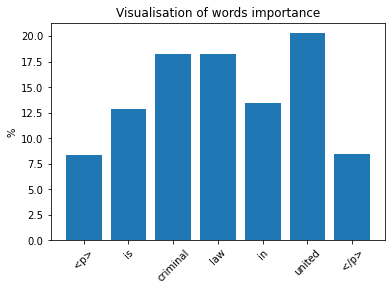

(tensor([[ 0.0075, -0.0473,  0.1262,  ...,  0.0150, -0.0130, -0.0319]],
        grad_fn=<MaxBackward0>),
 array([[0, 5, 5, ..., 3, 2, 5]], dtype=int64))

In [92]:
infersent.visualize('what is criminal law in united states?', tokenize=True)

In [93]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

def infersent_doc_retrieval(query):
    query_vec = infersent.encode([query])[0]
    similarity = []
    counter = 0
    for idx, row in df.iterrows():
        sim = cosine(query_vec, infersent_embeddings_loaded[counter])
        similarity.append((idx, sim))
        counter += 1
    return sorted(similarity, key=lambda x: x[1], reverse=True)[:10]

In [94]:
test_query = "what is criminal law in united states?"
infersent_mostsimilar = infersent_doc_retrieval(test_query)

for i in infersent_mostsimilar:
    print(f"Index / Score: {i}")
    print(f"Context: {df.loc[i[0],'context']}")
    print('------------')

Index / Score: (187, 0.37782925)
Context: In function and effectiveness, the UN has been compared to the pre-Constitutional United States Federal government by some[citation needed], giving a comparison between modern treaty law and the historical Articles of Confederation.
------------
Index / Score: (190, 0.37411663)
Context: The Brazilian federal constitution does not have a supremacy clause with the same effects as the one on the U.S. constitution, a fact that is of interest to the discussion on the relation between treaties and state legislation.
------------
Index / Score: (535, 0.37231565)
Context: The Supreme Court is the highest court in Ireland. It has authority to interpret the constitution, and strike down laws and activities of the state that it finds to be unconstitutional. It is also the highest authority in the interpretation of the law. Constitutionally it must have authority to interpret the constitution but its further appellate jurisdiction from lower courts is defi

## Method 7: InferSent + K-Means Clustering

In [95]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

In [96]:
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}

In [98]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    print(f"Iteration: {k}")
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(infersent_embeddings_loaded)
    sse.append(kmeans.inertia_)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


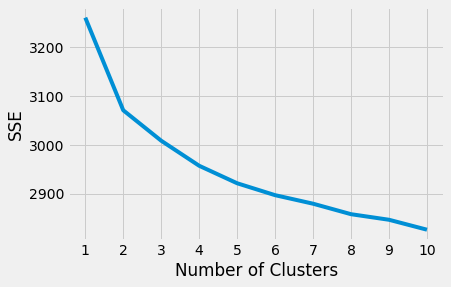

In [99]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [100]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

4

In [243]:
# To do: label docs to cluster, match new query to cluster and retrieve docs in that cluster

## ^ Not sure if this method makes sense? Like if we alr have the embeddings for each sentence, is there any benefit of clustering over direct cosine similarity?

## Method 8: Topic Modelling (LDA)
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [101]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [102]:
sentences = list(df['extractive_summarized_3_sent'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(sentences))

print(data_words[:1])

[['first', 'president', 'united', 'state', 'george', 'washington', 'inaugurated', 'first', 'united', 'state', 'congress', 'supreme', 'court', 'united', 'state', 'assembled', 'first', 'time', 'united', 'state', 'bill', 'right', 'drafted', 'federal', 'hall', 'wall', 'street', 'new', 'york', 'last', 'capital', 'article', 'confederation', 'first', 'capital', 'constitution', 'united', 'state', 'assembly', 'congress', 'confederation', 'made', 'new', 'york', 'national', 'capital', 'shortly', 'war']]


In [103]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['first', 'president', 'united', 'state', 'george', 'washington', 'inaugurated', 'first', 'united', 'state', 'congress', 'supreme', 'court', 'united', 'state', 'assembled', 'first', 'time', 'united', 'state', 'bill', 'right', 'drafted', 'federal', 'hall', 'wall', 'street', 'new_york', 'last', 'capital', 'article', 'confederation', 'first', 'capital', 'constitution', 'united', 'state', 'assembly', 'congress', 'confederation', 'made', 'new_york', 'national', 'capital', 'shortly', 'war']


In [104]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [105]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

In [106]:
print(data_words_bigrams[:1])

[['first', 'president', 'united', 'state', 'george', 'washington', 'inaugurated', 'first', 'united', 'state', 'congress', 'supreme', 'court', 'united', 'state', 'assembled', 'first', 'time', 'united', 'state', 'bill', 'right', 'drafted', 'federal', 'hall', 'wall', 'street', 'new_york', 'last', 'capital', 'article', 'confederation', 'first', 'capital', 'constitution', 'united', 'state', 'assembly', 'congress', 'confederation', 'made', 'new_york', 'national', 'capital', 'shortly', 'war']]


In [107]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 2), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 4), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 5), (23, 1), (24, 1), (25, 1), (26, 5), (27, 1), (28, 1), (29, 1)]]


### Building LDA Mallet Model

In [109]:
import os
os.environ.update({'MALLET_HOME':'C:/Users/User/Documents/GitHub/tmproj/document_retrieval/lda_mallet/mallet-2.0.8/'})

mallet_path = 'C:/Users/User/Documents/GitHub/tmproj/document_retrieval/lda_mallet/mallet-2.0.8/bin/mallet' # update this path

### Training LDA Mallet with Optimal Number of Topics

In [110]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=6)

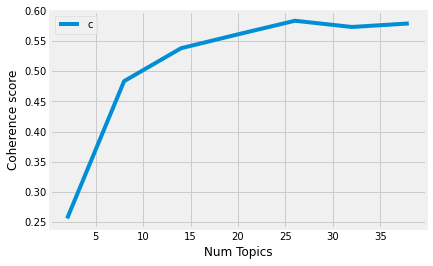

In [310]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [311]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2558
Num Topics = 8  has Coherence Value of 0.4835
Num Topics = 14  has Coherence Value of 0.5382
Num Topics = 20  has Coherence Value of 0.5612
Num Topics = 26  has Coherence Value of 0.5837
Num Topics = 32  has Coherence Value of 0.5734
Num Topics = 38  has Coherence Value of 0.5792


In [312]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(9,
  '0.023*"john" + 0.014*"woman" + 0.013*"death" + 0.013*"king" + '
  '0.013*"family" + 0.010*"royal" + 0.010*"men" + 0.008*"father" + 0.008*"son" '
  '+ 0.007*"william"'),
 (20,
  '0.047*"language" + 0.035*"term" + 0.027*"form" + 0.022*"english" + '
  '0.022*"word" + 0.019*"character" + 0.014*"common" + 0.012*"standard" + '
  '0.011*"meaning" + 0.011*"written"'),
 (10,
  '0.027*"company" + 0.025*"million" + 0.022*"world" + 0.020*"country" + '
  '0.019*"development" + 0.014*"economic" + 0.014*"industry" + 0.012*"market" '
  '+ 0.011*"billion" + 0.010*"economy"'),
 (16,
  '0.029*"th_century" + 0.024*"de" + 0.021*"early" + 0.020*"began" + '
  '0.019*"india" + 0.018*"european" + 0.017*"europe" + 0.016*"late" + '
  '0.015*"end" + 0.014*"established"'),
 (23,
  '0.047*"population" + 0.044*"people" + 0.024*"american" + 0.019*"group" + '
  '0.018*"community" + 0.018*"black" + 0.018*"number" + 0.016*"country" + '
  '0.015*"white" + 0.015*"child"'),
 (6,
  '0.055*"state" + 0.033*"law" + 0.0

In [331]:
## Save optimal LDA model as pkl file

# pickle.dump(optimal_model, open("lda_mallet/lda_optimal_model_2_apr.pkl", "wb"))

In [9]:
# Load optimal LDA model
optimal_lda_loaded = pickle.load(open("lda_mallet/lda_optimal_model_2_apr.pkl", "rb"))

### Finding the dominant topic in each sentence

In [19]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_lda_loaded, corpus=corpus, texts=data_words_bigrams)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(3)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,17.0,0.3502,"music, record, work, house, number, song, popular, artist, single, album","[born, raised, houston, texas, performed, various, singing, dancing, competition, child, rose, fame, late, lead, singer, girl, group, destiny_child, hiatus, saw, release, beyonce, debut_album, dangerously, love, established, solo_artist, worldwide, earned, five, grammy_award, featured, billboard_hot, number, one, single, crazy, love, baby, boy, beyonce, giselle, knowles, carter, bi, jansei, bee, yon, say, born, september, american, singer_songwriter, record, producer, actress]"
1,1,17.0,0.3887,"music, record, work, house, number, song, popular, artist, single, album","[beyonce, took, hiatus, music, took, management, career, fourth, album, subsequently, mellower, tone, exploring, funk, pop, soul, marriage, rapper, jay, portrayal, etta, james, cadillac, record, influenced, third, album, sasha_fierce, saw, birth, alter, ego, sasha_fierce, earned, record, setting, six, grammy_award, including, song, year, single, lady_put, ring, critically, acclaimed, fifth, studio_album, beyonce, distinguished, previous, release, experimental, production, exploration, darker, theme]"
2,2,17.0,0.2720,"music, record, work, house, number, song, popular, artist, single, album","[throughout, career, spanning, year, sold, million, record, solo_artist, million, destiny_child, making, one, best_selling, music, artist, time, stage, dynamic, highly, choreographed, performance, led, critic, hailing, one, best, entertainer, contemporary, popular, music, self, described, modern, day, feminist, beyonce, creates, song, often, characterized, theme, love, relationship, monogamy, well, female, sexuality, empowerment]"


In [20]:
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,17.0,0.3502,"music, record, work, house, number, song, popular, artist, single, album","[born, raised, houston, texas, performed, various, singing, dancing, competition, child, rose, fame, late, lead, singer, girl, group, destiny_child, hiatus, saw, release, beyonce, debut_album, dangerously, love, established, solo_artist, worldwide, earned, five, grammy_award, featured, billboard_hot, number, one, single, crazy, love, baby, boy, beyonce, giselle, knowles, carter, bi, jansei, bee, yon, say, born, september, american, singer_songwriter, record, producer, actress]"
1,17.0,0.3887,"music, record, work, house, number, song, popular, artist, single, album","[beyonce, took, hiatus, music, took, management, career, fourth, album, subsequently, mellower, tone, exploring, funk, pop, soul, marriage, rapper, jay, portrayal, etta, james, cadillac, record, influenced, third, album, sasha_fierce, saw, birth, alter, ego, sasha_fierce, earned, record, setting, six, grammy_award, including, song, year, single, lady_put, ring, critically, acclaimed, fifth, studio_album, beyonce, distinguished, previous, release, experimental, production, exploration, darker, theme]"
2,17.0,0.2720,"music, record, work, house, number, song, popular, artist, single, album","[throughout, career, spanning, year, sold, million, record, solo_artist, million, destiny_child, making, one, best_selling, music, artist, time, stage, dynamic, highly, choreographed, performance, led, critic, hailing, one, best, entertainer, contemporary, popular, music, self, described, modern, day, feminist, beyonce, creates, song, often, characterized, theme, love, relationship, monogamy, well, female, sexuality, empowerment]"
3,17.0,0.1815,"music, record, work, house, number, song, popular, artist, single, album","[beyonce, giselle, knowles, born, houston, texas, celestine, ann, tina, knowles, nee, beyince, hairdresser, salon, owner, mathew, knowles, xerox, sale, manager, beyonce, name, tribute, mother, maiden, name, beyonce, younger, sister, solange, also, singer, former, member, destiny_child]"
4,17.0,0.2467,"music, record, work, house, number, song, popular, artist, single, album","[fall, beyonce, enrolled, parker, elementary_school, music, magnet, school, houston, would, perform, school, choir, beyonce, interest, music, performing, continued, winning, school, talent, show, age, seven, singing, john_lennon, imagine, beat, year, old, singing, talent, discovered, dance, instructor, darlette, johnson, began, humming, song, finished, able, hit, high, pitched, note]"
...,...,...,...,...
18872,1.0,0.3722,"university, school, national, college, student, education, public, including, research, building","[number, medical, college, including, kathmandu, medical, college, nepal, medical, college, kist, medical, college, nepal, army, institute, health, science, national, academy, medical, science, nams, kathmandu, university, school, medical, science, kusms, also, located, around, kathmandu, institute, medicine, central, college, tribhuwan, university, first, medical, college, nepal, located, maharajgunj, kathmandu, established, started, impart, medical, education]"
18873,19.0,0.1942,"world, game, team, season, club, league, year, series, home, final","[international, football, stadium, city, dasarath, rangasala, stadium, multi, purpose, stadium, used, mostly, football, match, cultural, event, located, neighborhood, tripureshwor, football, cricket, popular, sport, among, younger, generation, nepal, several, stadium, city, stadium, renovated, chinese, help, th, south, asian, game, held, kathmandu, floodlight, installed]"
18874,10.0,0.1158,"company, million, world, country, development, economic, industry, market, billion, economy","[fairly, large, network, helped, economic, development, country, particularly, field, agriculture, horticulture, vegetable, farming, industry, also, tourism, view, hilly, terrain, transportation, take_place, kathmandu,

### Find the most representative document for each topic

In [21]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3762,"th_century, greek, period, modern, early, century, roman, culture, bc, building","[notable, modern, greek, artist, include, renaissance, painter, dominikos, theotokopoulos, el, greco, panagiotis, doxaras, nikolaos, gyzis, nikiphoros, lytras, yannis, tsarouchis, nikos, engonopoulos, constantine, andreou, jannis, kounellis, sculptor, leonidas, drosis, georgios, bonanos, yannoulis, chalepas, joannis, avramidis, conductor, dimitri, mitropoulos, soprano, maria, calla, composer, mikis, theodorakis, nikos, skalkottas, iannis, xenakis, manos, hatzidakis, eleni, karaindrou, yanni, vangelis, one, best_selling, singer, worldwide, nana, mouskouri, poet, kostis, palamas, dionysios, solomos, angelos, sikelianos, yannis, ritsos, alexandrian, constantine, cavafy, nobel_laureate, giorgos, seferis, odysseas, elytis, among, important, poet, th_century, novel, also, represented, alexandros, papadiamantis, nikos, kazantzakis]"
1,1.0,0.5058,"university, school, national, college, student, education, public, including, research, building","[year, later, university, north_carolina, system, encompasses, public, university, including, north_carolina, state, university, north_carolina, state, university, north_carolina, central, university, university, north_carolina, chapel_hill, university, north_carolina, greensboro, east, carolina, university, western, carolina, university, winston_salem, state, university, university, north_carolina, asheville, university, north_carolina, charlotte, university, north_carolina, pembroke, unc, wilmington, elizabeth, city, state, university, appalachian, state, university, fayetteville, state, university, unc, school, art, along, public, university, north_carolina, public, community, college, community, college, system, largest, university, north_carolina, currently, north_carolina, state, university, student, north_carolina, home, many, excellent, university, well, dozen, community, college, private, university]"
2,2.0,0.4185,"empire, french, german, power, france, war, germany, part, paris, state","[ottoman_empire, at, ottoman, turkish, dawlati, aliywh, uthmaniywh, devlet, aliyye, osmaniyye, modern, turkish, osmanli, imparatorlugu, osmanli, devleti, also, known, turkish, empire, ottoman, turkey, turkey, empire, founded, oghuz, turk, osman, northwestern, anatolia, conquest, balkan, murad, ottoman, sultanate, transformed, empire, claimant, caliphate, ottoman, ended, byzantine_empire, conquest, constantinople, mehmed, conqueror]"
3,3.0,0.4221,"high, due, film, current, level, le, low, result, rate, higher","[addition, lower, radiation_resistance, reactance, becomes, higher, antenna, size, reduced, resonant, circuit, formed, antenna, tuning, coil, factor, rise, eventually, cause, bandwidth, antenna, inadequate, signal, transmitted, example, mhz, wavelength, true, resonant, wavelength, monopole, would, almost, meter, long, using, antenna, meter, tall, would, require, addition, loading, coil, however, resulting, resistive, impedance, achieved, quite, bit, lower, impedance, resonant, monopole, likely, requiring, impedance_matching]"
4,4.0,0.4447,"water, energy, material, form, source, process, power, made, wood, mass","[ortho, para, ratio, condensed, important, consideration, preparation, storage, liquid, hydrogen, conversion, ortho, para, exothermic, produce, enough, heat, evaporate, hydrogen, liquid, leading, loss, liquefied, material, uncatalyzed, interconversion, para, ortho, increase, increasing, temperature, thus, rapidly, condensed, contains, large, quantity, high, energy, ortho, form, convert, para, form, slowly, catalyst, ortho, para, interconversion, ferric, oxide, activated, carbon, platinized, asbestos, rare, earth, metal, uranium, compound, chromic, oxide, nickel, compound, used, hydrogen, cooling]"
5,5.0,0.4140,"specie, plant, human, found, animal, group, life, bird, including, number","[montana, department, fish_wildlife, park, manages, fishing, hunti

## Get Law Related Docs
Obtain legal subset for demo

In [30]:
df.iloc[df_topic_sents_keywords[df_topic_sents_keywords['Dominant_Topic']==6].index, :].to_csv('squad_legal_paras_lda.csv')

### Topic distribution across documents

In [364]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum()*100, 2).astype(str) + '%'

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"th_century, greek, period, modern, early, century, roman, culture, bc, building",844,4.47%
1.0,1.0,"university, school, national, college, student, education, public, including, research, building",796,4.22%
2.0,2.0,"empire, french, german, power, france, war, germany, part, paris, state",846,4.48%
3.0,3.0,"high, due, film, current, level, le, low, result, rate, higher",325,1.72%
4.0,4.0,"water, energy, material, form, source, process, power, made, wood, mass",725,3.84%
5.0,5.0,"specie, plant, human, found, animal, group, life, bird, including, number",622,3.3%
6.0,6.0,"state, law, government, party, president, court, federal, member, political, council",1080,5.72%
7.0,7.0,"force, war, army, military, general, battle, operation, attack, british, air",1043,5.53%
8.0,8.0,"year, time, day, average, month, event, hour, long, space, july",476,2.52%
9.0,9.0,"john, woman, death, king, family, royal, men, father, son, william",754,3.99%


### Finding dominant topic of a new query
https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc

In [393]:
def get_query_topic(query):
    tokens = clean_lowercase_nostop_lem(query).split()
    scores = sorted(optimal_lda_loaded[id2word.doc2bow(tokens)], key=lambda x: x[1], reverse=True)
    for i in scores:
        print(f"Topic: {i[0]}, Score: {str(round(i[1]*100,2)) + '%'}, Top Keywords: {df_dominant_topics.iloc[i[0],1].split()[:3]}")
    return scores[0][0]

In [394]:
get_query_topic('obama was the president of the united states')

Topic: 6, Score: 6.85%, Top Keywords: ['state,', 'law,', 'government,']
Topic: 13, Score: 5.41%, Top Keywords: ['order,', 'member,', 'policy,']
Topic: 15, Score: 5.41%, Top Keywords: ['country,', 'china,', 'government,']
Topic: 19, Score: 3.77%, Top Keywords: ['world,', 'game,', 'team,']
Topic: 2, Score: 3.77%, Top Keywords: ['empire,', 'french,', 'german,']
Topic: 0, Score: 3.56%, Top Keywords: ['th_century,', 'greek,', 'period,']
Topic: 1, Score: 3.56%, Top Keywords: ['university,', 'school,', 'national,']
Topic: 3, Score: 3.56%, Top Keywords: ['high,', 'due,', 'film,']
Topic: 4, Score: 3.56%, Top Keywords: ['water,', 'energy,', 'material,']
Topic: 5, Score: 3.56%, Top Keywords: ['specie,', 'plant,', 'human,']
Topic: 7, Score: 3.56%, Top Keywords: ['force,', 'war,', 'army,']
Topic: 8, Score: 3.56%, Top Keywords: ['year,', 'time,', 'day,']
Topic: 9, Score: 3.56%, Top Keywords: ['john,', 'woman,', 'death,']
Topic: 10, Score: 3.56%, Top Keywords: ['company,', 'million,', 'world,']
Topic

6